<a href="https://colab.research.google.com/github/dpshepherd/PHY452_F2023/blob/main/PHY452_F2024_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unmixing off-axis hologram data

# Exercise goal
The goal of this lab is to unmix the off-axis digital hologram image that you have been provided.

# Experiment background

You have been provided two off-axis hologram images of a [$10 \mu m$ polystyrene microspheres](https://www.thermofisher.com/order/catalog/product/F8836) embedded in glue ($n=1.5$) between two glass coverslips ($n=1.515$). The laser source is a [stabilized $785$ nm laser diode](https://www.thorlabs.com/thorproduct.cfm?partnumber=FPL785P). The incident beam k-vector lies along the optical axis and the angle of the off-axis reference beam, with respect to the optical axis, is unknown.

The camera is has a pixel size of $10 \mu m$ and the imaging system has an overall imaging magnfication of $180\times$, yielding an effective pixel size of $0.075 \mu m$. The detection objective is a water immersion model with $NA = 1.0$.

# Theory background

Building on our previous lectures, we know that the electric field, $E(x,y)$ at the plane of interference (the camera sensor) is given by,

$|E(x,y)|^2 = |R(x,y)|^2 + |O(x,y)|^2 + O^*(x,y)R(x,y) + O(x,y)R^*(x,y)$,

with $R$ denoting the reference field and $O$ denoting the object field.

It is useful to think about the real space and reciprocal space configuration just before the camera (see class notes).

Generally, we try to satisfy $\alpha_{max} \sim \frac{\lambda}{2 \Delta x}$, where $\Delta x$ is the effective camera pixel spacing. This ensure that all of the holographic data is contained within the accessible frequency space given the discrete pixel sizes.

It is easiest to unmix the holograms in the Fourier domain,

$\mathcal{F}[|E(x,y)|^2] = \mathcal{F}[|R(x,y)|^2 + |O(x,y)|^2] + \mathcal{F}[O^*(x,y)R(x,y)] + \mathcal{F}[O(x,y)R^*(x,y)]$.

Remember that $R(x,y) = E_Re^{-i\vec{k}_R \cdot \vec{r}}$, which we can plug into the terms we are interested in above to give ($\ast$ denotes convolution),

$\mathcal{F}[O^*(x,y)R(x,y)] = \tilde{O}(\vec{k})^* \ast \mathcal{F}[E_Re^{+i\vec{k}_R \cdot \vec{r}}] $,

and

$\mathcal{F}[O(x,y)R^*(x,y)] = \tilde{O}(\vec{k}) \ast \mathcal{F}[E_Re^{-i\vec{k}_R \cdot \vec{r}}] $.

These contain redundant information, so we will just focus on the second equation. Pratically, it will be fine for unmixing.

From HW #4-5 and our practice with the Fourier shift thm., we know that that $\mathcal{F}[E_Re^{+i\vec{k}_R \cdot \vec{r}}] = \delta (\vec{k}+\vec{k}_R)$, yielding,

$\mathcal{F}[O(x,y)R^*(x,y)] = \tilde{O}(\vec{k}) \ast \delta (\vec{k}+\vec{k}_R)] = \tilde{O}(\vec{k}+\vec{k}_R)$.

The quantity we are interested in is $\tilde{O}(\vec{k})$, which means we need to use the shift thm. and the known reference frequencies to shift back.

$\tilde{O}(k) = \tilde{O}(\vec{k}+\vec{k}_R) \ast \mathcal{F}[E_Re^{-i\vec{k}_R \cdot \vec{r}}]$.

That means from our data, we need to:
1. Find and isolate the area of the digital hologram in reciprocal space that corresponds to $\mathcal{F}[O(x,y)R^*(x,y)]$. HINT: It should be the one at positive $k_x$ and $k_y$.
2. Find the reference frequency, $\vec{k}_R$.
3. Use the Fourier shift thm. to shift the digital hologram in reciprocal space.
4. Take the inverse discrete Fourier Transform to obtain the electric fields that correspond to the incident + scattered field from the object.


# Computational approach

### load Python computational and plotting libraries

In [ ]:
!pip install ipympl --quiet
from google.colab import output
output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.1 MB/s eta 0:00:00


In [ ]:
%matplotlib ipympl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from google.colab import files
from tifffile import imread

### Load the raw off-axis hologram.

In [ ]:
dict_files = files.upload()

Saving PHY452_F2023_hologram.tif to PHY452_F2023_hologram.tif


Copy the name that Google saved the file into and paste inside the single quotes below.

In [ ]:
raw_data = imread('PHY452_F2023_hologram.tif')
raw_data = raw_data[0:-1,0:-1] # make sure array is odd shape, this helps with numerical Fourier transforms

### Create spatial coordinates using pixel spacing with center pixel corresponding to $(x=0,y=0)$.

Remember that python ordering is yx for this array.

In [ ]:
camera_pixel_size = 0.1 # microns
x_axis = np.arange(-raw_data.shape[1]/2,raw_data.shape[1]/2)*camera_pixel_size
y_axis = np.arange(-raw_data.shape[0]/2,raw_data.shape[0]/2)*camera_pixel_size
ny, nx = raw_data.shape

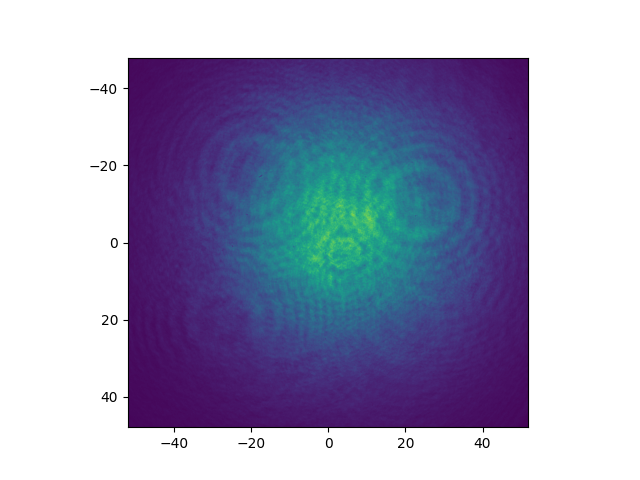

In [ ]:
fig, ax = plt.subplots()

# Display the image with specified axes
ax.imshow(raw_data, extent=[x_axis[0], x_axis[-1], y_axis[-1], y_axis[0]]) # for extent, I switched order for y axis because the top left should be the (0,0) value of the array. But extent uses the bottom left by default.

plt.show()

### Calculate discrete Fourier Transform using [numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html). Ensure center pixel of FFT corresponds to $(k_x=0,k_y=0)$ and the pixel spacing is correct in reciprocal space.

In [ ]:
img_ft = np.fft.fftshift(np.fft.fft2(raw_data))

fy_axis =  np.fft.fftshift(np.fft.fftfreq(raw_data.shape[0],d=camera_pixel_size))
fx_axis = np.fft.fftshift(np.fft.fftfreq(raw_data.shape[1], d=camera_pixel_size))

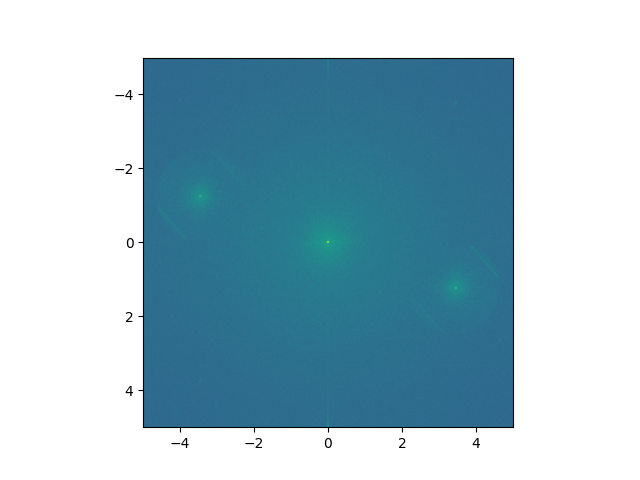

X value -3.43 ; Y value -1.2


In [ ]:
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print('X value '+str(np.round(ix,2))+' ; Y value ' +str(np.round(iy,2)))

fig, ax = plt.subplots()

ax.imshow(np.abs(img_ft),
           norm=colors.PowerNorm(gamma=0.1),
           extent=[fx_axis[0],fx_axis[-1],fy_axis[-1],fy_axis[0]])

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

### Determine reference beam frequency ($k_R$).

In [ ]:
fx_R = -3.43
fy_R = -1.2
# upper left data

### Replot the data in matrix coordinates to figure out where to cut data out

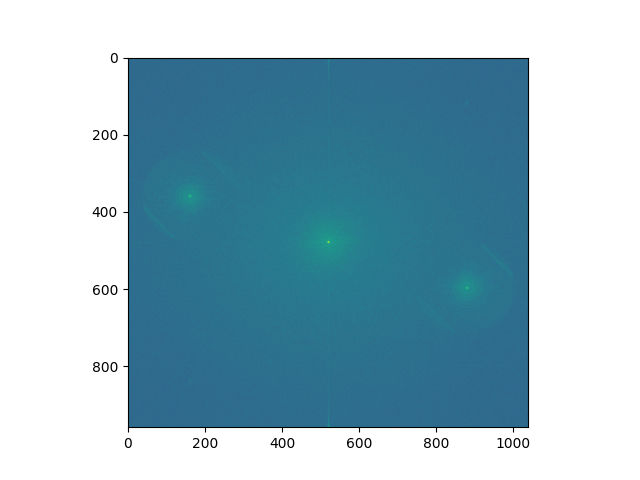

X value 28.6 ; Y value 374.17
X value 285.48 ; Y value 366.39
X value 163.53 ; Y value 226.28
X value 168.72 ; Y value 483.15


In [ ]:
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print('X value '+str(np.round(ix,2))+' ; Y value ' +str(np.round(iy,2)))

fig, ax = plt.subplots()

ax.imshow(np.abs(img_ft),
           norm=colors.PowerNorm(gamma=0.1))

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

### Define bounding box for off-axis hologram information to use

In [ ]:
x_lower_bound = 30
x_upper_bound = 290
y_lower_bound = 230
y_upper_bound = 490

### Clear data outside of desired off-axis component (either $\mathcal{F}[O^*R]$ or $\mathcal{F}[OR^*]$).

Cut out the off-axis hologram, place it in the middle of a new array, and pad that array to match the size of our original hologram.

In [ ]:
img_ft_cropped = np.zeros_like(img_ft)
# ensure crop is odd sized
crop_width = x_upper_bound - x_lower_bound
crop_height = y_upper_bound - y_lower_bound

if crop_width % 2 == 0:
    x_upper_bound += 1
    crop_width += 1

if crop_height % 2 == 0:
    y_upper_bound += 1
    crop_height += 1

# Extract the cropped area
img_ft_cropped[y_lower_bound:y_upper_bound, x_lower_bound:x_upper_bound] = img_ft[y_lower_bound:y_upper_bound, x_lower_bound:x_upper_bound]

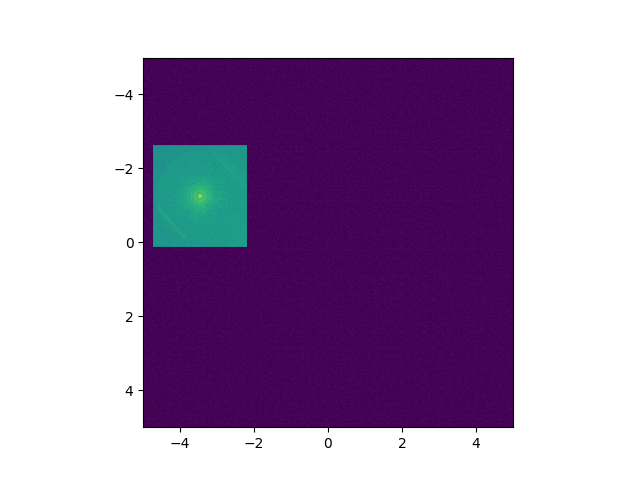

In [ ]:
fig, ax = plt.subplots()

ax.imshow(np.abs(img_ft_cropped),
           norm=colors.PowerNorm(gamma=0.1),
          extent=[fx_axis[0],fx_axis[-1],fy_axis[-1],fy_axis[0]])

plt.show()

### Construct the reference beam matrix to use in the Fourier shift thm.

In [ ]:
ny, nx = img_ft.shape

ref_matrix = np.zeros_like(img_ft_cropped)

x_idx = 0
y_idx = 0
for y_value in y_axis:
  for x_value in x_axis:
    ref_matrix[y_idx,x_idx] = np.exp(-1j*2*np.pi*(x_value*fx_R+y_value*fy_R))
    x_idx = x_idx + 1
  y_idx = y_idx + 1
  x_idx = 0

### Use Fourier shift thm. to recover $\tilde{O}(k_x,k_y)$.

Given img_ft(f), return the translated function

img_ft_shifted(f) = img_ft(f + shift_frq)

using the FFT shift relationship,

img_ft(f + shift_frq) = F[ exp(-2*pi*i * shift_frq * r) * img(r) ]


In [ ]:
img_ft_shifted = np.fft.fftshift(np.fft.fft2(ref_matrix * np.fft.ifft2(np.fft.ifftshift(img_ft_cropped))))

Plot $\tilde{O}(k_x,k_y)$.

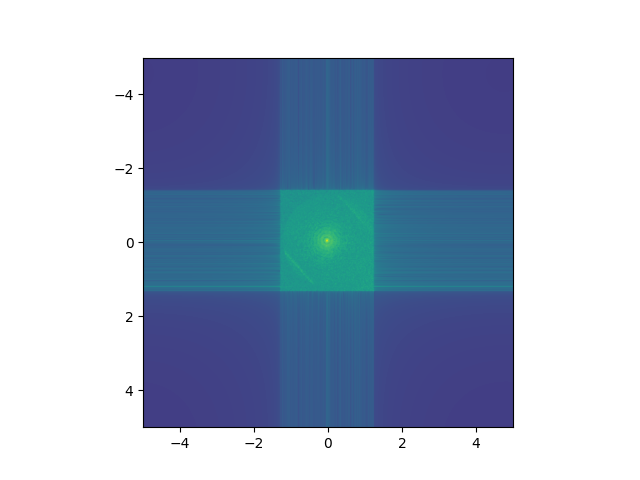

In [ ]:
ax.imshow(np.abs(img_ft_shifted),
           norm=colors.PowerNorm(gamma=0.1),
          extent=[fx_axis[0],fx_axis[-1],fy_axis[-1],fy_axis[0]])
plt.show()

### Finally, use the inverse FFT to recover $O(x,y)$.

In [ ]:
img_recovered = np.fft.ifft2(np.fft.ifftshift(img_ft_shifted))


Plot $O(x,y)O^*(x,y)$.

<ipython-input-51-750096bcca8c>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


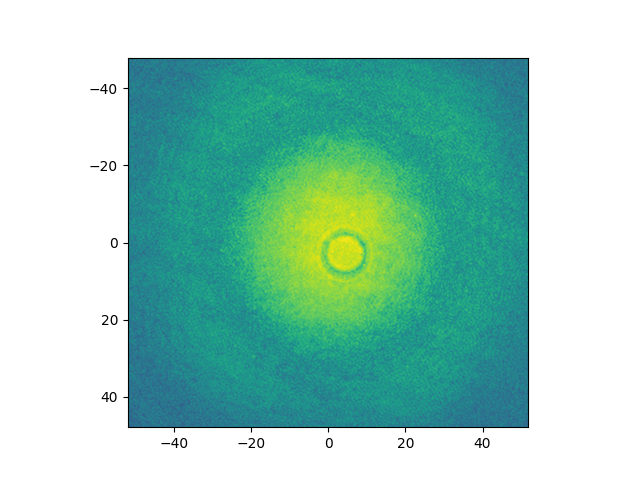

In [ ]:
fig, ax = plt.subplots()

ax.imshow((img_recovered*np.conjugate(img_recovered)).real,
           norm=colors.PowerNorm(gamma=0.1),
          extent=[x_axis[0],x_axis[-1],y_axis[-1],y_axis[0]])

plt.show()

Plot $Re(O(x,y))$

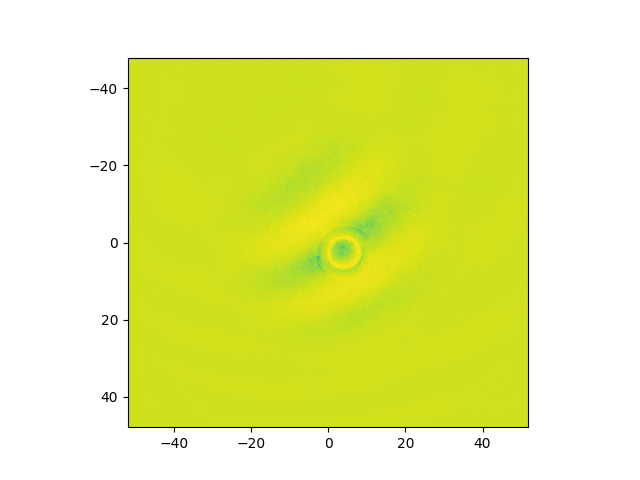

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img_recovered.real,
           norm=colors.PowerNorm(gamma=0.1),
          extent=[x_axis[0],x_axis[-1],y_axis[-1],y_axis[0]])

plt.show()

Plot $Im(O(x,y))$

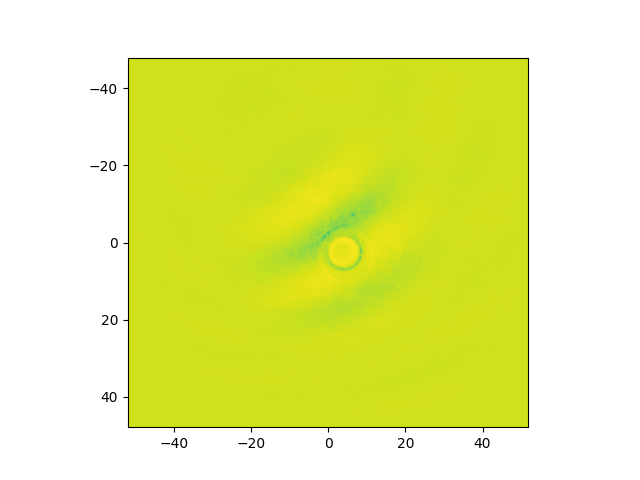

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img_recovered.imag,
           norm=colors.PowerNorm(gamma=0.1),
          extent=[x_axis[0],x_axis[-1],y_axis[-1],y_axis[0]])

plt.show()

### Does $O(x,y)$ match your expectations? What more can you learn about the object based on what we have done in class?